In [ ]:
import os
import cv2
import PIL
import copy
import time
import torch
import shutil
import random
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import datasets
import matplotlib.image as mpimg
from torchvision import transforms
from torch.optim import lr_scheduler
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #  transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomAffine([-90,90]),
        transforms.Resize([400,400]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([400,400]),                       
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


In [ ]:
data_dir = "/content/drive/My Drive/path/Dataset"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(dataset_sizes['train'])
print(dataset_sizes['val'])
print(dataset_sizes['train']+dataset_sizes['val'])


1952
836
2788


In [ ]:
image_datasets['val'].class_to_idx

{'Defective': 0, 'Good': 1}

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # if(phase == 'val'): 
                    #   print(labels)
                    #   print(outputs)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # print(labels)
            # print(outputs)

            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/My Drive/path/ATTEMPT_2.pth")
    return model

In [ ]:
vgg19 = models.vgg19(pretrained=True)

for param in vgg19.parameters():
    param.requires_grad_(False)
vgg19.classifier = nn.Sequential(
                    nn.Linear(25088,4096,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(4096,2048,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(2048,2,bias = True)
                    )
vgg19  = vgg19.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer1 = optim.SGD(vgg19.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)

In [ ]:
# vgg19.load_state_dict(torch.load("/content/drive/My Drive/path/ATTEMPT_2.pth"))
# vgg19.eval()
vgg19 = train_model(vgg19,criterion, optimizer1,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6126 Acc: 0.6742
val Loss: 0.4814 Acc: 0.7907

Epoch 1/24
----------
train Loss: 0.5276 Acc: 0.7387
val Loss: 0.5305 Acc: 0.7572

Epoch 2/24
----------
train Loss: 0.4942 Acc: 0.7597
val Loss: 0.4946 Acc: 0.8002

Epoch 3/24
----------
train Loss: 0.4526 Acc: 0.7889
val Loss: 0.4186 Acc: 0.8230

Epoch 4/24
----------
train Loss: 0.4480 Acc: 0.7941
val Loss: 0.4332 Acc: 0.8074

Epoch 5/24
----------
train Loss: 0.4359 Acc: 0.7987
val Loss: 0.4390 Acc: 0.8098

Epoch 6/24
----------
train Loss: 0.4141 Acc: 0.8094
val Loss: 0.4217 Acc: 0.8206

Epoch 7/24
----------
train Loss: 0.4120 Acc: 0.8207
val Loss: 0.4207 Acc: 0.8158

Epoch 8/24
----------
train Loss: 0.3925 Acc: 0.8274
val Loss: 0.4231 Acc: 0.8098

Epoch 9/24
----------
train Loss: 0.3683 Acc: 0.8391
val Loss: 0.4087 Acc: 0.8158

Epoch 10/24
----------
train Loss: 0.3779 Acc: 0.8335
val Loss: 0.4110 Acc: 0.8122

Epoch 11/24
----------
train Loss: 0.3738 Acc: 0.8407
val Loss: 0.4603 Acc: 0.7967

Ep

In [ ]:
# data_dir = "/content/drive/My Drive/path/data_Attempt4/val"
# transform = transforms.Compose([transforms.Resize([300,300]),
#                                  transforms.ToTensor(),
#                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# real_dataset = datasets.ImageFolder(data_dir,transform)
# dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=4,
#                                            shuffle=True, num_workers=4)
real_dataset = image_datasets['val']
dataloader = dataloaders['val']
dataset_size =  len(real_dataset)
class_names = real_dataset.classes
print(real_dataset.class_to_idx)
print("size:",dataset_size)

{'Defective': 0, 'Good': 1}
size: 836


In [ ]:
def test_accuracy(model):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    TP=0.0
    FP=0.0
    FN=0.0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)
        TP+=torch.sum(preds+labels.data == 2)
        FP+=torch.sum(preds-labels.data==1)
        FN+=torch.sum(preds-labels.data==-1)
                
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    epoch_pre = TP/(TP+FP)
    epoch_rec = TP/(TP+FN)
    epoch_Fscore = 2*epoch_pre/(epoch_pre+epoch_rec)
    
    # print('test Loss: {:.4f} Acc: {:.4f}'.format(
    #       epoch_loss, epoch_acc))

    print()

    time_elapsed = time.time() - since
  Class of 2020  print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(epoch_acc))
    print('Precision: {:.4f}'.format(epoch_pre))
    print('Recall: {:.4f}'.format(epoch_rec))
    print('Fscore {:.4f}'.format(epoch_Fscore))

    return

In [ ]:
test_accuracy(vgg19)


Testing complete in 2m 2s
Test Acc: 0.822967


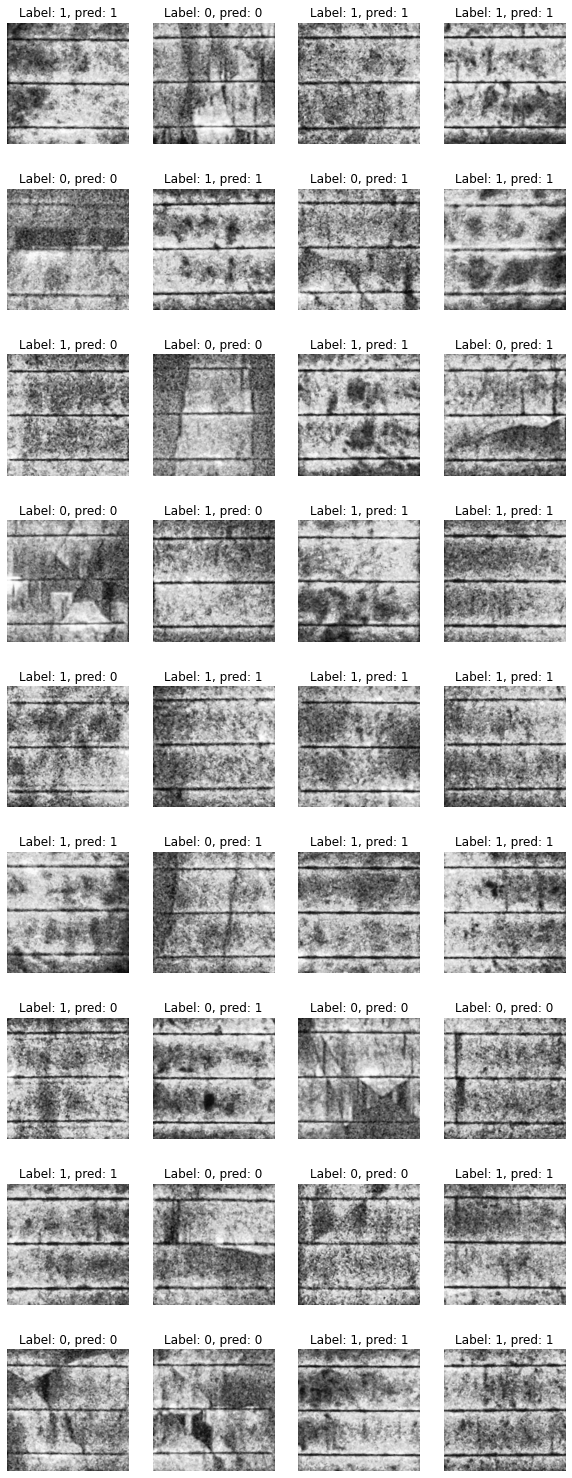

In [ ]:
#converts normalised tensor input to denormalised numpy array 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5]) #this mean array was used during normalisation
    std = np.array([0.5,0.5,0.5])  #this std array was used during normalisation
    inp = std * inp + mean # normalising formulae was: inp = (inp-mean)/std
    inp = np.clip(inp, 0, 1) # scaling the val in the range [0,1]
    plt.imshow(inp)

# for visulaisation;
vgg19.eval()  #This would change the state if model is in trian mode
              #,to eval mode. remember to change it back to its original
              # state.
 
num_images=36 #multiple of 4, the batch size and also i have chose to represent
              # 4 images in a row.
images_so_far =0              
fig = plt.figure(figsize=(10,30))
with torch.no_grad():
  for i,(inputs, labels) in enumerate(dataloader,0):
  
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = vgg19(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(4): # 4 is the batch size
      images_so_far += 1
       #4 images in a row
       # images_so_far< rows(=1+num_images//4)*cols(=4)
      ax = plt.subplot(num_images//4+1, 4, images_so_far)   
      ax.axis('off')
      ax.set_title('Label: {}, pred: {}'.format(labels[j],preds[j]))
      imshow(inputs.cpu().data[j])
    if images_so_far >= num_images:
        break

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_Fscore = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            TP=0.0
            FP=0.0
            FN=0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # if(phase == 'val'): 
                    #   print(labels)
                    #   print(outputs)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                TP+=torch.sum(preds+labels.data == 2)
                FP+=torch.sum(preds-labels.data==1)
                FN+=torch.sum(preds-labels.data==-1)
                
            # print(labels)
            # print(outputs)

            if phase == 'train':
                scheduler.step()
            # print(TP)
            # print(FP)
            # print(FN)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_pre = TP/(TP+FP)
            epoch_rec = TP/(TP+FN)
            epoch_Fscore = 2*epoch_pre/(epoch_pre+epoch_rec)
            
            print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                  phase, epoch_loss, epoch_acc))

            print('Precision: {:.4f} Recall: {:.4f}'.format(
                  epoch_pre,epoch_rec))
            print('Fscore {:.4f}'.format(
                  epoch_Fscore))

            # deep copy the model
            if phase == 'val' and epoch_Fscore > best_Fscore:
                best_Fscore = epoch_Fscore
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Fscore: {:4f}'.format(best_Fscore))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/My Drive/path/ATTEMPT_3.pth")
    return model